In [1]:
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import nquad, quad
from scipy.special import logsumexp
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
from math import log
import seaborn as sb
import itertools
from scipy.stats import norm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:

np.random.seed(42)
N = 200
X_vec = np.random.uniform(-10,10,N)
true_beta = 2
true_sigma = 5
epsilon = np.random.randn(N) * true_sigma
y_vec = X_vec * true_beta + epsilon
S_1 = 400
sig2 = 10

In [3]:
def Hamiltonian(Theta: np.ndarray, X_vec: np.ndarray, y_vec: np.ndarray, S_1: float, sig2: float) -> np.ndarray:
    """
        H(Theta) = 0.5*exp(-Theta_2)*(y - X*Theta_1)^T(y - X*Theta_1) + 0.5*N*Theta_2 + 0.5*Theta_1^T*Theta_1/S_1 + 0.5*Theta_2^2/sig2^2
        where:
            Theta = [Theta_1, Theta_2]
    """
    theta1 = Theta[0]
    theta2 = Theta[1]
    m_sig = np.exp(-theta2)
    y_hat = y_vec - (X_vec * theta1)
    n = X_vec.shape[0]

    term1 = 0.5 * m_sig * np.dot(y_hat.T, y_hat)
    term2 = 0.5 * n * theta2
    term3 = 0.5 * (theta1**2) / S_1
    term4 = 0.5 * (theta2**2) / (sig2**2)

    return np.array([term1 + term2 + term3 + term4])

def HamiltonianPrime(Theta: np.ndarray, X_vec: np.ndarray, y_vec: np.ndarray, S_1: float, sig2: float) -> np.ndarray:
    """
        Derivative of Hamiltonian wrt Theta
    """
    theta2 = Theta[0]
    m_sig = np.exp(-theta2)
    XTX = np.dot(X_vec.T, X_vec)
    theta1 = (1/((m_sig * XTX) + (1 / S_1))) * ((m_sig * np.dot(X_vec.T, y_vec)))
    y_hat = y_vec - X_vec * theta1
    n = X_vec.shape[0]

    return np.abs((n*0.5 + theta2/sig2**2 - 0.5*m_sig*np.dot(y_hat.T, y_hat)))

# print(fsolve(Hamiltonian, x0=np.array([0.1,0.1]), args=(X_vec, y_vec, S_1, sig2)))
def MAP_Solutions(X_vec: np.ndarray, y_vec: np.ndarray, S_1: float, sig2: float):
    """
        MAP solutions for Theta_1 and Theta_2
    """
    theta_20 = fsolve(HamiltonianPrime, x0=np.array([0.1]), args=(X_vec, y_vec, S_1, sig2))
    m_sig = np.exp(-theta_20)
    XTX = np.dot(X_vec.T, X_vec)
    theta_10 = (1/((m_sig * XTX) + (1 / S_1))) * ((m_sig * np.dot(X_vec.T, y_vec)))
    return np.array([theta_10, theta_20]).reshape(2,)



In [4]:

def j_vec(Theta: np.ndarray)->np.ndarray:
    theta1 = Theta[0]
    theta2 = Theta[1]
    y_hat = y_vec - X_vec * theta1
    N = X_vec.shape[0]
    return np.array([
        np.exp(-theta2) * np.dot(X_vec.T,y_hat) - (theta1 / S_1),
        0.5 * np.exp(-theta2) * np.dot(y_hat.T,y_hat) - (0.5 * N) - (theta2 / sig2**2)
    ]).reshape(2,)

def D_mat(Theta: np.ndarray)->np.ndarray:
    theta1 = Theta[0]
    theta2 = Theta[1]
    _y_hat = y_vec - X_vec * theta1
    Dinv = np.diag([
        1/S_1 + np.exp(-theta2)*np.dot(X_vec.T,X_vec),
        1/sig2**2 + 0.5*np.exp(-theta2)*np.dot(_y_hat.T,_y_hat)
    ])
    Dinv[0,1] = Dinv[1,0] = np.exp(-theta2) * np.dot(X_vec.T,_y_hat)
    D = np.linalg.inv(Dinv)
    return D, Dinv

In [5]:
map_sol = MAP_Solutions(X_vec, y_vec, S_1, sig2)
print(f"MAP Solutions: {map_sol}")

m2 = map_sol[1]
X = X_vec
y = y_vec
yhat = y - map_sol[0]*X
Lmbd = []
Lmbd.append([999])
Lmbd.append([9999])
Lmbd.append([99999])
for i in range(3,11):
    temp = np.zeros(tuple(2 for _ in range(i)))
    temp.flat[2**i - 1] = (-1)**i * 0.5*np.exp(-m2)*np.dot(np.transpose(yhat),yhat)

    poslist = set(list(itertools.permutations([0 if x<1 else 1 for x in range(i)])))
    for k in list(poslist):
        temp[k] = (-1)**i * np.exp(-m2)*np.dot(np.transpose(yhat),X)

    poslist = set(list(itertools.permutations([0 if x<2 else 1 for x in range(i)])))
    for k in list(poslist):
        temp[k] = (-1)**(i-2) * np.exp(-m2)*np.dot(np.transpose(X),X)
    Lmbd.append(temp)

MAP Solutions: [1.97741698 3.15475887]


In [6]:
with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=0, sigma=np.sqrt(S_1))
    log_sigma2 = pm.Normal('log_sigma2', mu=0, sigma=(sig2))
    sigma2 = pm.Deterministic('sigma2', pm.math.exp(log_sigma2))
    sigma = pm.Deterministic('sigma', pm.math.sqrt(sigma2))

    # Likelihood
    likelihood = pm.Normal('y', mu=X_vec * beta, sigma=sigma, observed=y_vec)

    # Sampling
    trace = pm.sample(1000, chains=4, return_inferencedata=True)

# Get moments (as well as some parameters to check convergence. Feel free to read up on the parameters.)
print(az.summary(trace))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, log_sigma2]


/Users/uliraudales/Desktop/Research/IFT/IFT_Code/.venv/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta         1.978  0.060   1.866    2.089      0.001    0.001    4772.0   
log_sigma2   3.165  0.102   2.968    3.342      0.002    0.001    4562.0   
sigma        4.874  0.248   4.411    5.318      0.004    0.003    4562.0   
sigma2      23.817  2.432  19.458   28.284      0.036    0.026    4562.0   

            ess_tail  r_hat  
beta          3110.0    1.0  
log_sigma2    3364.0    1.0  
sigma         3364.0    1.0  
sigma2        3364.0    1.0  


In [7]:
j = j_vec(map_sol)
D, Dinv = D_mat(map_sol)
print('j: ', j)
print('D: ', D)
print('Dinv: ', Dinv)

j:  [ 3.15580895e-14 -1.35724765e-14]
D:  [[ 3.37731292e-03 -1.66889560e-07]
 [-1.66889560e-07  9.99584697e-03]]
Dinv:  [[2.96093381e+02 4.94354246e-03]
 [4.94354246e-03 1.00041548e+02]]


In [8]:
mu0 = np.dot(D,j)
mu3 = (-0.5*np.einsum('ij,jkl,kl',D,Lmbd[3],D) -0.5*np.einsum('ij,jkl,km,m,ln,n',D,Lmbd[3],D,j,D,j))
mu4 = (-0.5*np.einsum('ij,jklm,kl,mn,n',D,Lmbd[4],D,D,j)
        -(1/6)*np.einsum('ij,jklm,kn,n,lo,o,mp,p',D,Lmbd[4],D,j,D,j,D,j))
mu5 = (-(1/8)*np.einsum('ij,jklmn,kl,mn',D,Lmbd[5],D,D)-
        (1/4)*np.einsum('ij,jklmn,ko,o,lp,p,mn',D,Lmbd[5],D,j,D,j,D)-
        (1/24)*np.einsum('ij,jklmn,ko,o,lp,p,mq,q,nr,r',D,Lmbd[5],D,j,D,j,D,j,D,j))
mu6 = (-(1/8)*np.einsum('ij,jklmno,kl,mn,op,p',D,Lmbd[6],D,D,D,j)-
        (1/12)*np.einsum('ij,jklmno,kl,mp,p,nq,q,or,r',D,Lmbd[6],D,D,j,D,j,D,j)-
        (1/120)*np.einsum('ij,jklmno,kp,p,lq,q,mr,r,ns,s,ot,t',D,Lmbd[6],D,j,D,j,D,j,D,j,D,j)+
        (1/2)*np.einsum('ij,jkl,km,ln,mno,op,p',D,Lmbd[3],D,D,Lmbd[3],D,j)+
        (1/2)*np.einsum('ij,jkl,km,m,ln,nop,op',D,Lmbd[3],D,j,D,Lmbd[3],D)+
        (1/2)*np.einsum('ij,jkl,km,m,ln,nop,oq,q,pr,r',D,Lmbd[3],D,j,D,Lmbd[3],D,j,D,j))
mu7 = (-(1/48)*np.einsum('ij,jklmnop,kl,mn,op',D,Lmbd[7],D,D,D)-
        (1/16)*np.einsum('ij,jklmnop,kl,mn,oq,q,pr,r',D,Lmbd[7],D,D,D,j,D,j)-
        (1/48)*np.einsum('ij,jklmnop,kl,mq,q,nr,r,os,s,pt,t',D,Lmbd[7],D,D,j,D,j,D,j,D,j)-
        (1/720)*np.einsum('ij,jklmnop,kq,q,lr,r,ms,s,nt,t,ou,u,pv,v',D,Lmbd[7],D,j,D,j,D,j,D,j,D,j,D,j)+
        (1/4)*np.einsum('ij,jklm,kl,mn,nop,op',D,Lmbd[4],D,D,Lmbd[3],D)+
        (1/4)*np.einsum('ij,jkl,km,ln,mnop,op',D,Lmbd[3],D,D,Lmbd[4],D)+
        (1/6)*np.einsum('ij,jklm,kn,lo,mp,nop',D,Lmbd[4],D,D,D,Lmbd[3])+
        (1/2)*np.einsum('ij,jkl,km,m,ln,nopq,or,r,pq',D,Lmbd[3],D,j,D,Lmbd[4],D,j,D)+
        (1/4)*np.einsum('ij,jkl,km,ln,mnop,or,r,ps,s',D,Lmbd[3],D,D,Lmbd[4],D,j,D,j)+
        (1/4)*np.einsum('ij,jklm,kl,mn,nop,oq,q,pr,r',D,Lmbd[4],D,D,Lmbd[3],D,j,D,j)+
        (1/2)*np.einsum('ij,jklm,kn,n,lo,mp,opq,qr,r',D,Lmbd[4],D,j,D,D,Lmbd[3],D,j)+
        (1/4)*np.einsum('ij,jklm,kn,n,lo,o,mp,pqr,qr',D,Lmbd[4],D,j,D,j,D,Lmbd[3],D)+
        (1/6)*np.einsum('ij,jkl,km,m,ln,nopq,or,r,ps,s,qt,t',D,Lmbd[3],D,j,D,Lmbd[4],D,j,D,j,D,j)+
        (1/4)*np.einsum('ij,jklm,kn,n,lo,o,mp,pqr,qs,s,rt,t',D,Lmbd[4],D,j,D,j,D,Lmbd[3],D,j,D,j))
mu = mu0+mu3+mu4+mu5+mu6+mu7

In [9]:
print(mu)
print(map_sol)
print(map_sol + mu)
ip = map_sol + mu

[-2.41569603e-07  9.79141297e-03]
[1.97741698 3.15475887]
[1.97741674 3.16455028]


In [10]:
# 4th order correction
d1 = -(1/8)*np.einsum('ijkl,ij,kl',Lmbd[4],*[D]*2)
# 6th order correction
d2 = -(1/48)*np.einsum('ijklmn,ij,kl,mn',Lmbd[6],*[D]*3) + (1/8)*np.einsum('ijk,lmn,ij,kl,mn',Lmbd[3],Lmbd[3],*[D]*3) + (1/12)*np.einsum('ijk,lmn,il,jm,kn',Lmbd[3],Lmbd[3],*[D]*3)
# 8th order correction
d3 = -(1/384)*np.einsum('ijklmnop,ij,kl,mn,op',Lmbd[8],*[D]*4) + (1/96)*np.einsum('ijkl,mnop,ij,km,ln,op',Lmbd[4],Lmbd[4],*[D]*4) + (1/48)*np.einsum('ijkl,mnop,im,jn,ko,lp',Lmbd[4],Lmbd[4],*[D]*4) + (1/32)*np.einsum('ijklm,nop,ij,kl,mn,op',Lmbd[5],Lmbd[3],*[D]*4) + (1/12)*np.einsum('ijk,lmnop,il,jm,kn,op',Lmbd[3],Lmbd[5],*[D]*4)
# 10th order correction
d4 = -(1/3840)*np.einsum('ijklmnopuv,ij,kl,mn,op,uv',Lmbd[10],*[D]*5) + (1/240)*np.einsum('ijklm,nopuv,in,jo,kp,lu,mv',Lmbd[5],Lmbd[5],*[D]*5) + (1/4)*np.einsum('ijklm,nopuv,ij,kn,lo,mp,uv',Lmbd[5],Lmbd[5],*[D]*5) + (1/128)*np.einsum('ijklm,nopuv,ij,kl,mn,op,uv',Lmbd[5],Lmbd[5],*[D]*5) + (1/384)*np.einsum('ijklmn,opuv,ij,kl,mp,no,uv',Lmbd[6],Lmbd[4],*[D]*5) + (1/48)*np.einsum('ijklmno,puv,ij,kl,mn,op,uv',Lmbd[7],Lmbd[3],*[D]*5) - (1/72)*np.einsum('ijk,lmn,opuv,ij,ko,lm,np,uv',Lmbd[3],Lmbd[3],Lmbd[4],*[D]*5) - (1/24)*np.einsum('ijk,lmn,opuv,ij,ko,pl,mu,nv',Lmbd[3],Lmbd[3],Lmbd[4],*[D]*5)
d = d1 + d2 + d3 + d4
d

0.004610268604638277

In [11]:
H0map = Hamiltonian(map_sol, X_vec, y_vec, S_1, sig2)[0]
circ =  np.log(np.sqrt(np.linalg.det(2*np.pi*D)))
lnZ = -H0map + circ + d
ZIFT = np.exp(lnZ)
print(f'ln(Z) = {lnZ} (Z = {ZIFT})')

ln(Z) = -418.8677277872742 (Z = 1.2247774299374653e-182)


In [12]:
print(-H0map)
print(circ)

-415.562084894502
-3.3102531613768567


In [13]:
Npts = 200
thetas_1 = np.linspace(0,5,Npts)
thetas_2 = np.linspace(0,7,Npts)

def Q(Theta1, Theta2, X_vec, y_vec, S_1, sig2):
    Theta = np.array([Theta1, Theta2])
    H = Hamiltonian(Theta, X_vec, y_vec, S_1, sig2)
    return np.exp(-H)

# double integral over theta_1 and theta_2, dblquad gives the same result
N_Z, error = nquad(Q, [[-np.inf, np.inf], [-np.inf,np.inf]], args=(X_vec, y_vec, S_1, sig2))
print('Z: ', N_Z)
print('ln Z: ', log(N_Z), 'Z: ', N_Z)
print('Z error: ', error)

Z:  1.491207554773228e-183
ln Z:  -420.9734857867366 Z:  1.491207554773228e-183
Z error:  3.220516218719679e-183


In [14]:

b_0_run = trace.posterior['beta'][0]
b_1_run = trace.posterior['beta'][1]
b_2_run = trace.posterior['beta'][2]
b_3_run = trace.posterior['beta'][3]

l_0_run = trace.posterior['log_sigma2'][0]
l_1_run = trace.posterior['log_sigma2'][1]
l_2_run = trace.posterior['log_sigma2'][2]
l_3_run = trace.posterior['log_sigma2'][3]

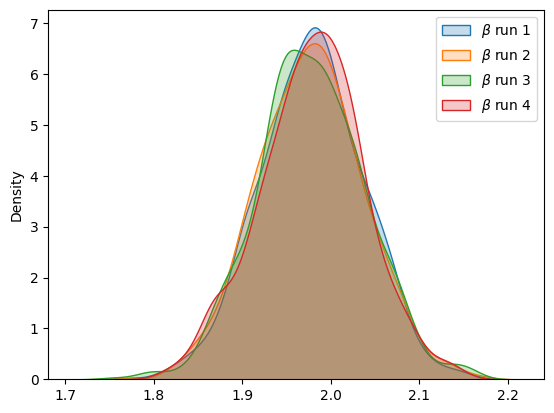

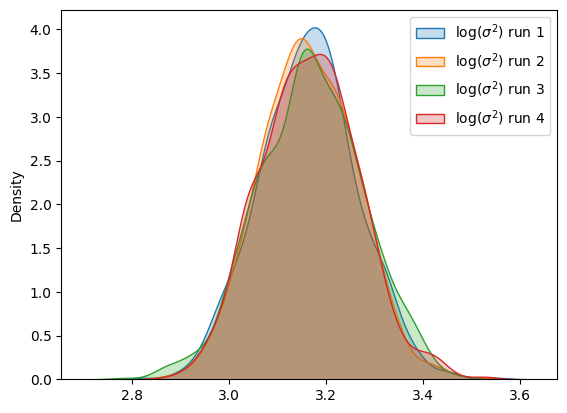

In [15]:

# For beta runs
sb.kdeplot(b_0_run, label=r"$\beta$ run 1", fill=True)
sb.kdeplot(b_1_run, label=r"$\beta$ run 2", fill=True)
sb.kdeplot(b_2_run, label=r"$\beta$ run 3", fill=True)
sb.kdeplot(b_3_run, label=r"$\beta$ run 4", fill=True)
plt.legend()
plt.show()

# For log sigma2 runs
sb.kdeplot(l_0_run, label=r"$\log(\sigma^{2})$ run 1", fill=True)
sb.kdeplot(l_1_run, label=r"$\log(\sigma^{2})$ run 2", fill=True)
sb.kdeplot(l_2_run, label=r"$\log(\sigma^{2})$ run 3", fill=True)
sb.kdeplot(l_3_run, label=r"$\log(\sigma^{2})$ run 4", fill=True)
plt.legend()
plt.show()

In [16]:
# for integrating with respect to theta1
def P1(Theta1, Theta2, X_vec, y_vec, S_1, sig2):
    thetas = np.array([Theta1, Theta2])
    H = Hamiltonian(thetas, X_vec, y_vec, S_1, sig2)
    return np.exp(-H)

# for integrating with respect to theta2
def P2(Theta2, Theta1, X_vec, y_vec, S_1, sig2):
    thetas = np.array([Theta1, Theta2])
    H = Hamiltonian(thetas, X_vec, y_vec, S_1, sig2)
    return np.exp(-H)


In [17]:
P1_vals = np.zeros(Npts)
P2_vals = np.zeros(Npts)

P1_IFT_vals = np.zeros(Npts)
P2_IFT_vals = np.zeros(Npts)
for i in range(Npts):
    # for j in range(Npts):
    P1_, err2 = quad(P1, -np.inf, np.inf, args=(thetas_2[i], X_vec, y_vec, S_1, sig2))
    P2_, err2 = quad(P2, -np.inf, np.inf, args=(thetas_1[i], X_vec, y_vec, S_1, sig2))
#    P3_, err2 = quad(P1, -np.inf, np.inf, args=(thetas_2[i], X_vec, y_vec, S_1, sig2))
#    P4_, err2 = quad(P2, -np.inf, np.inf, args=(thetas_1[i], X_vec, y_vec, S_1, sig2))
    P1_IFT_vals[i] = (P1_ / ZIFT)
    P2_IFT_vals[i] = (P2_ / ZIFT)
    P1_vals[i] = (P1_ / N_Z)
    P2_vals[i] = (P2_ / N_Z)

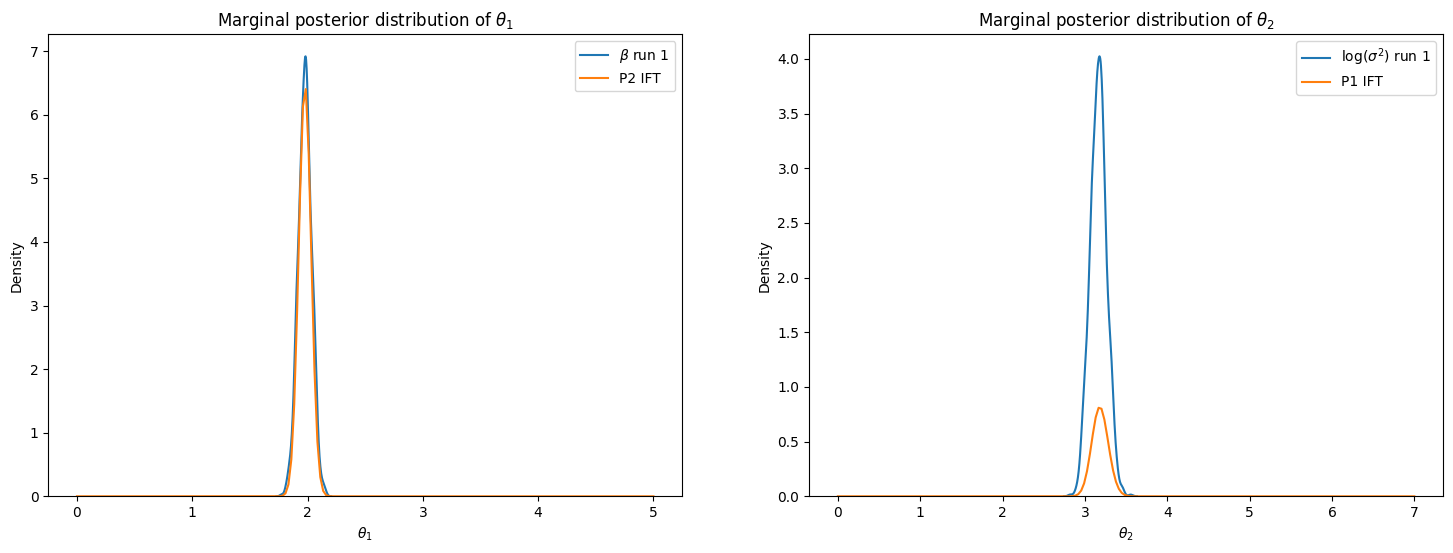

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# For beta runs
sb.kdeplot((b_0_run), label=r"$\beta$ run 1", ax=ax[0])
#sb.kdeplot(b_1_run, label=r"$\beta$ run 2", ax=ax[0])
#sb.kdeplot(b_2_run, label=r"$\beta$ run 3", ax=ax[0])
#sb.kdeplot(b_3_run, label=r"$\beta$ run 4", ax=ax[0])

# For log sigma2 runs
sb.kdeplot((l_0_run), label=r"$\log(\sigma^{2})$ run 1", ax=ax[1])
#sb.kdeplot(l_1_run, label=r"$\log(\sigma^{2})$ run 2", ax=ax[1])
#sb.kdeplot(l_2_run, label=r"$\log(\sigma^{2})$ run 3", ax=ax[1])
#sb.kdeplot(l_3_run, label=r"$\log(\sigma^{2})$ run 4", ax=ax[1])

# Plot the marginal posterior distributions
#ax[0].plot(thetas_1, P2_vals, label='P2')
ax[0].plot(thetas_1, P2_IFT_vals, label="P2 IFT")
ax[0].set_xlabel(r"$\theta_1$")
ax[0].set_ylabel("Density")
ax[0].set_title(r"Marginal posterior distribution of $\theta_1$")
ax[0].legend()

#ax[1].plot(thetas_2, P1_vals, label="P1")
ax[1].plot(thetas_2, P1_IFT_vals, label="P1 IFT")
ax[1].set_xlabel(r"$\theta_2$")
ax[1].set_ylabel("Density")
ax[1].set_title(r"Marginal posterior distribution of $\theta_2$")
ax[1].legend()



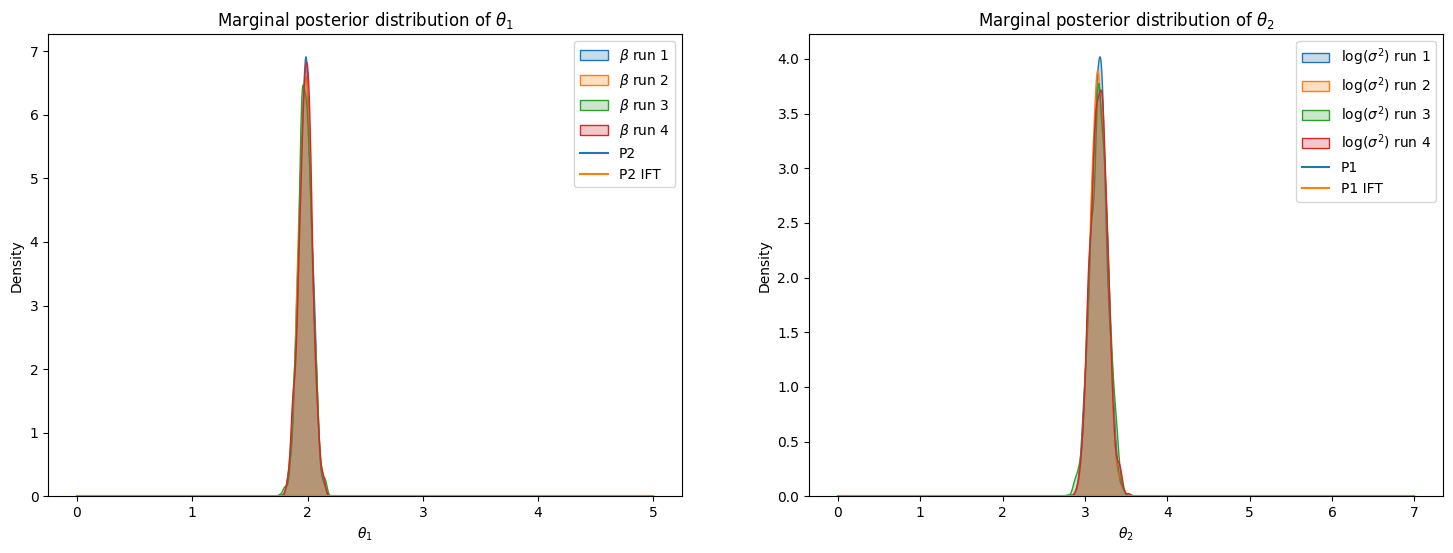

In [19]:
for i in range(N):
    P1_IFT_vals[i] /= 1e88
    P2_IFT_vals[i] /= 1e88
    P1_vals[i] /= 1e87
    P2_vals[i] /= 1e87


fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# For beta runs
sb.kdeplot(b_0_run, label=r"$\beta$ run 1", ax=ax[0], fill=True)
sb.kdeplot(b_1_run, label=r"$\beta$ run 2", ax=ax[0], fill=True)
sb.kdeplot(b_2_run, label=r"$\beta$ run 3", ax=ax[0], fill=True)
sb.kdeplot(b_3_run, label=r"$\beta$ run 4", ax=ax[0], fill=True)

# For log sigma2 runs
sb.kdeplot(l_0_run, label=r"$\log(\sigma^{2})$ run 1", ax=ax[1], fill=True)
sb.kdeplot(l_1_run, label=r"$\log(\sigma^{2})$ run 2", ax=ax[1], fill=True)
sb.kdeplot(l_2_run, label=r"$\log(\sigma^{2})$ run 3", ax=ax[1], fill=True)
sb.kdeplot(l_3_run, label=r"$\log(\sigma^{2})$ run 4", ax=ax[1], fill=True)

# Plot the marginal posterior distributions
ax[0].plot(thetas_1, P2_vals, label='P2')
ax[0].plot(thetas_1, P2_IFT_vals, label="P2 IFT")
ax[0].set_xlabel(r"$\theta_1$")
ax[0].set_ylabel("Density")
ax[0].set_title(r"Marginal posterior distribution of $\theta_1$")
ax[0].legend()

ax[1].plot(thetas_2, P1_vals, label="P1")
ax[1].plot(thetas_2, P1_IFT_vals, label="P1 IFT")
ax[1].set_xlabel(r"$\theta_2$")
ax[1].set_ylabel("Density")
ax[1].set_title(r"Marginal posterior distribution of $\theta_2$")
ax[1].legend()

